In [1]:
# IMPORTS
import re
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import Dataset, Subset
from transformers import AutoTokenizer, AutoModelForCausalLM, PreTrainedModel, TrainingArguments, Trainer

In [2]:
#DIRECTORIES

DATA_PATH = "../input/harry-potter-lstm/Harry_Potter_all_books.txt"
SAVED_MODEL_PATH = os.scandir('/kaggle/input/harry-potter-text-generator-transformers/weights').__next__().path

In [3]:
#Load the file
text = open(DATA_PATH, "r", encoding="utf-8").read().lower()
sentences = re.split('[.!?]', text)

93.0


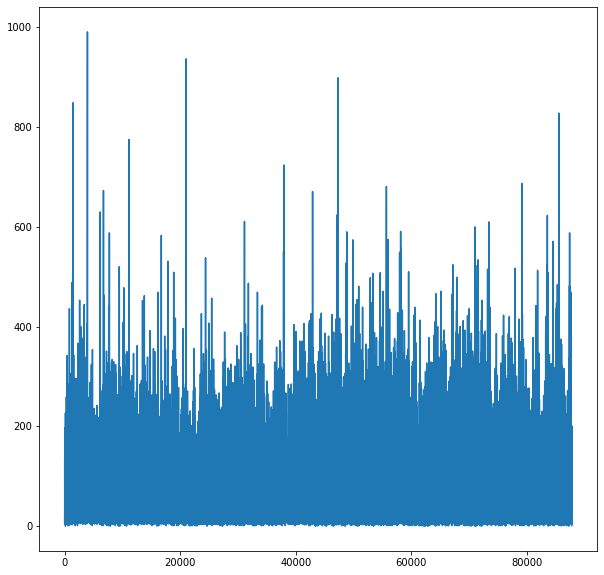

In [4]:
lenghts = [len(sentence) for sentence in sentences]
print(np.percentile(lenghts, 75))

plt.figure(figsize=(10,10))
plt.plot(lenghts)
plt.show()

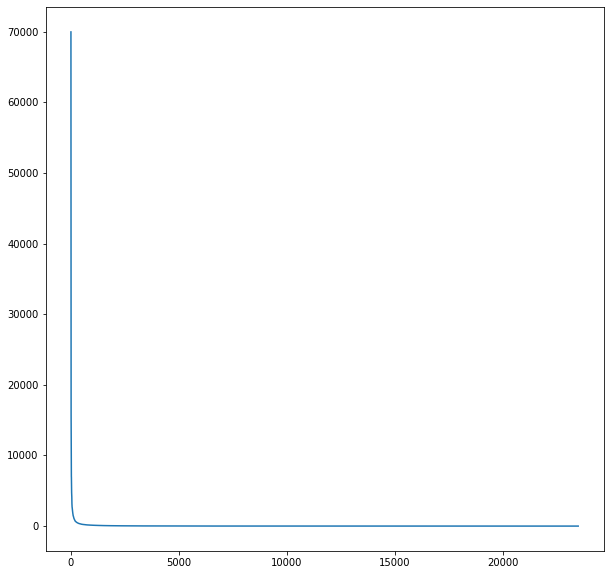

In [5]:
words = text.split()
words_unique = Counter(words).most_common()
dictionary = {}
for word in words_unique:
    dictionary[word[0]] = word[1]
dict_values = list(dictionary.values())

plt.figure(figsize=(10,10))
plt.plot(dict_values)
plt.show()

In [4]:
#Transformers
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = AutoModelForCausalLM.from_pretrained(SAVED_MODEL_PATH, local_files_only=True)
#model = AutoModelForCausalLM.from_pretrained("distilgpt2") #weights for fine tuning

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [5]:
tokenizer.pad_token = tokenizer.eos_token
data_token = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True, max_length=85)

In [6]:
MAX_LENGTH = 85

class Harry_dataset(Dataset):
    def __init__(self, sentences, tokenizer, max_length):
        self.input_ids = []
        self.attn_masks = []
        self.labels = []
        for sentence in sentences:
            encodings_dict = tokenizer('<|startoftext|>' + sentence + '<|endoftext|>', truncation=True,
                                       max_length=max_length, padding="max_length")
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]
    

dataset = Harry_dataset(sentences, tokenizer, max_length=MAX_LENGTH)
train_dataset = dataset
#train_size = int(0.9 * len(dataset))
#train_dataset = Subset(dataset, list(range(0, train_size)))
#val_dataset = Subset(dataset, list(range(train_size, len(dataset))))

In [9]:
training_args = TrainingArguments(output_dir='./weights', num_train_epochs=5, logging_steps=500,
                                  logging_strategy='steps', save_strategy='epoch',
                                  per_device_train_batch_size=32,
                                  warmup_steps=10, save_total_limit=1, weight_decay=0.05, report_to='none')

In [ ]:
Trainer(model=model,  args=training_args, train_dataset=train_dataset, 
        data_collator=lambda data: {'input_ids': torch.stack([f[0] for f in data]),
                                                              'attention_mask': torch.stack([f[1] for f in data]),
                                                              'labels': torch.stack([f[0] for f in data])}).train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 87804
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 13720


Step,Training Loss


In [ ]:
#Loss after training - 0.32

In [18]:
begin = 'Mr . and Mrs . Dursley of number four Privet Drive were proud to say that they were perfectly normal thank you very much . They were the last people youd expect to be involved in anything strange or mysterious because they just didnt hold with such nonsense .'
generated = tokenizer.encode(begin, return_tensors='pt').cuda()
attention_mask = torch.ones_like(generated)
sample_outputs = model.generate(generated, do_sample=True, top_k=10, max_new_tokens=200, min_length=100, top_p=1, temperature=1.4, no_repeat_ngram_size=5, attention_mask=attention_mask, pad_token_id=tokenizer.eos_token_id)[0]
tokenizer.decode(sample_outputs, skip_special_tokens=True)

'Mr. and Mrs. Dursley of number four Privet Drive were proud to say that they were perfectly normal thank you very much. They were the last people youd expect to be involved in anything strange or mysterious because they just didnt hold with such nonsense. of a button hearing startly voice and a hugful voice  ive just seen a tiny boy dudleys scream ernie macmill half an anyone ron ron gasped ive good part his fists justin t crookin half an fool '

In [ ]:
#compress folder to zip file
import shutil
shutil.make_archive("GPT2_weights", 'zip', "./checkpoint-25000")